# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [ ]:
import importlib
import data
importlib.reload(data)

from data import * #create_dir, load_data, augment_data

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, AUC

# Data Reading

In [ ]:
# Seeding
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load data
data_path = "/content/drive/MyDrive/Datasets/DRIVE_Shared/DRIVE"
(train_x, train_y), (test_x, test_y) = load_data(data_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test:  {len(test_x)} - {len(test_y)}")

Train: 20 - 20
Test:  20 - 20


In [ ]:
import imageio
m1 = imageio.mimread(train_y[0])[0]
m2 = imageio.mimread(test_y[0])[0]
np.unique(m1), np.unique(m2)

(array([  0, 255], dtype=uint8), array([  0, 255], dtype=uint8))

In [ ]:
# Create directories
create_dir("new_data/train/image")
create_dir("new_data/train/mask")
create_dir("new_data/test/image")
create_dir("new_data/test/mask")

# Augmentation

In [ ]:
augment_data(train_x, train_y, "new_data/train/", augment=True)
augment_data(test_x,  test_y,  "new_data/test/",  augment=False)

100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


In [ ]:
def binarize_augmented_masks(mask_dir):
    """Read every .png mask under mask_dir, threshold it at 127, and
    overwrite it with a strictly 0-or-255 image."""
    for mask_path in glob(os.path.join(mask_dir, "*.png")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # any pixel >127 becomes 255, else 0
        _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        cv2.imwrite(mask_path, binary)

In [ ]:
# apply to train & test masks
binarize_augmented_masks("new_data/train/mask")
binarize_augmented_masks("new_data/test/mask")

# Model Building

In [ ]:
import model
importlib.reload(model)

from model import *

In [ ]:
import metrics
importlib.reload(metrics)

from metrics import *

In [ ]:
H = 512
W = 512

In [ ]:
""" Directory to save files """
create_dir("files")

In [ ]:
""" Hyperparameters """
batch_size = 8
lr = 1e-4
num_epochs = 100
model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "data.csv")

In [ ]:
""" Dataset """
dataset_path = "new_data"

### Augmented Data Loading

In [ ]:
# Load augmented data
(train_x, train_y), (test_x, test_y) = load_data("new_data", augmented=True)
print(f"Augmented Train: {len(train_x)} - {len(train_y)}")
print(f"Augmented Test:  {len(test_x)} - {len(test_y)}")

Augmented Train: 120 - 120
Augmented Test:  20 - 20


In [ ]:
train_x, train_y = shuffling(train_x, train_y)

In [ ]:
from sklearn.model_selection import train_test_split

## Train-Test Split

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

print(f"Train after split: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train after split: 108 - 108
Valid: 12 - 12


In [ ]:
batch_size = 8

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size)
test_dataset = tf_dataset(test_x, test_y, batch_size)

In [ ]:
# Calculate steps
train_steps = len(train_x) // batch_size
valid_steps = len(valid_x) // batch_size

In [ ]:
if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_steps += 1

## Model

In [ ]:
""" Model """
model = build_unet((H, W, 3))


# model.compile(
#     loss=dice_loss,
#     optimizer=Adam(lr),
#     metrics=[
#         dice_coef,
#         iou,
#         Recall(name="recall"),
#         Precision(name="precision"),
#         BinaryAccuracy(name="accuracy"),
#         AUC(name="auc")
#     ]
# )

## Loss Fn

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def soft_cldice_loss(iter_=3, smooth=1.0):
    def soft_skel(x):
        def erode(x):
            return 1.0 - tf.nn.max_pool2d(1.0 - x, ksize=3, strides=1, padding='SAME')
        skel = x
        for _ in range(iter_):
            skel = skel * erode(skel)
        return skel

    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, 0.0, 1.0)
        S_true = soft_skel(y_true)
        S_pred = soft_skel(y_pred)

        inter1 = K.sum(y_pred * S_true)
        inter2 = K.sum(y_true * S_pred)
        sum1   = K.sum(y_pred) + K.sum(S_true)
        sum2   = K.sum(y_true) + K.sum(S_pred)

        C = (2.0 * inter1 + smooth) / (sum1 + smooth)
        D = (2.0 * inter2 + smooth) / (sum2 + smooth)

        return 1.0 - (C * D)

    return loss_fn

bce = tf.keras.losses.BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)           # or 1 – dice_coef
    cld  = soft_cldice_loss(iter_=3, smooth=1.0)(y_true, y_pred)
    return 1.0*bce(y_true, y_pred) + 1.0*dice + 1.0*cld



model.compile(
    loss=combined_loss, #soft_cldice_loss(iter_=3, smooth=1.0),
    optimizer=Adam(lr),
    metrics=[
        dice_coef,
        iou,
        Recall(name="recall"),
        Precision(name="precision"),
        BinaryAccuracy(name="accuracy"),
        AUC(name="auc"),
    ]
)


In [ ]:
# model.summary()

In [ ]:
callbacks = [
    ModelCheckpoint(model_path, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

## Model Training

In [ ]:
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 259s 9s/step - accuracy: 0.5034 - auc: 0.7146 - dice_coef: 0.1879 - iou: 0.1041 - loss: 3.1395 - precision: 0.1301 - recall: 0.8169 - val_accuracy: 0.5926 - val_auc: 0.4028 - val_dice_coef: 0.1518 - val_iou: 0.0823 - val_loss: 3.0496 - val_precision: 0.0065 - val_recall: 0.0229 - learning_rate: 1.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8523 - auc: 0.9057 - dice_coef: 0.2713 - iou: 0.1575 - loss: 2.6799 - precision: 0.3465 - recall: 0.7868 - val_accuracy: 0.8649 - val_auc: 0.5756 - val_dice_coef: 0.1539 - val_iou: 0.0835 - val_loss: 2.9883 - val_precision: 0.1195 - val_recall: 0.0761 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9288 - auc: 0.9387 - dice_coef: 0.3652 - iou: 0.2242 - loss: 2.4006 - precision: 0.5632 - recall: 0.7467 - val_accuracy: 0.9088 - val_auc: 0.6333 - val_dice_coef: 0.1482 - val_iou: 0.0801 - val_loss: 2.8498 - val_precision: 0.0000e+00 - val_rec

In [ ]:
model.evaluate(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.9636 - auc: 0.9511 - dice_coef: 0.7556 - iou: 0.6078 - loss: 1.5364 - precision: 0.8249 - recall: 0.7526


[1.5332272052764893,
 0.7570702433586121,
 0.6095269322395325,
 0.7602313160896301,
 0.8182503581047058,
 0.9642858505249023,
 0.9527708888053894]

# Evaluation

In [ ]:
results = model.evaluate(test_dataset)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 0.9636 - auc: 0.9511 - dice_coef: 0.7556 - iou: 0.6078 - loss: 1.5364 - precision: 0.8249 - recall: 0.7526
loss: 1.5332272052764893
compile_metrics: 0.7570702433586121


In [ ]:
from tensorflow.keras.utils import CustomObjectScope

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import pandas as pd

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    ori_x = x.copy()
    x = x / 255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    ori_x = x.copy()
    x = x / 255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y]*3, axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred]*3, axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
height, width = ori_y.shape[:2]

## Storing The Performance Score In CSV

In [ ]:
""" Save the results in this folder """
create_dir("results")

""" Load the model (corrected model path and extension) """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss, 'combined_loss': combined_loss}):
    model = tf.keras.models.load_model("files/model.keras")

""" Prediction and evaluation """
SCORE = []
for x_path, y_path in tqdm(zip(test_x, test_y), total=len(test_x)):
    name = os.path.basename(x_path).split(".")[0]

    ori_x, x = read_image(x_path)
    ori_y, y = read_mask(y_path)

    y_pred = model.predict(np.expand_dims(x, axis=0), verbose=0)[0]
    y_pred = (y_pred > 0.5).astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    y = y.flatten()
    y_pred = y_pred.flatten()

    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    jac = jaccard_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    # Before computing loss, reshape y and y_pred, according to cobined loss structure
    y_for_comb_loss = tf.convert_to_tensor(y.reshape(1, height, width, 1), dtype=tf.float32)
    y_pred_for_comb_loss = tf.convert_to_tensor(y_pred.reshape(1, height, width, 1), dtype=tf.float32)

    COMBINED_LOSS = combined_loss(y_for_comb_loss, y_pred_for_comb_loss).numpy().item()

    SCORE.append([name, acc, f1, jac, recall, precision, COMBINED_LOSS])

score = np.mean([s[1:] for s in SCORE], axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"combined_loss: {score[5]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Combined_Loss"])
df.to_csv("files/score.csv", index=False)


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]

Accuracy: 0.96429
F1: 0.78742
Jaccard: 0.64983
Recall: 0.76219
Precision: 0.81934
combined_loss: 1.78538


In [ ]:
score

array([0.96428585, 0.78742077, 0.64982851, 0.76218769, 0.81933517,
       1.78538067])

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Random Predicted Image Plot with GT

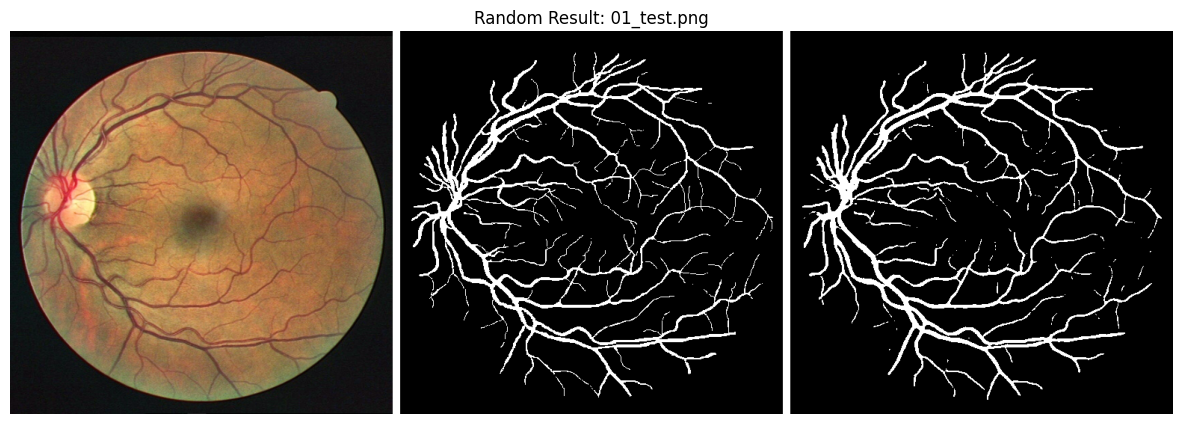

In [ ]:


# Set path to results directory
results_path = "/content/results"

# Get list of all PNG images in the directory
image_files = [f for f in os.listdir(results_path) if f.endswith(".png")]

# Pick a random image
random_image = random.choice(image_files)
image_path = os.path.join(results_path, random_image)

# Read the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

# Display the image
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.title(f"Random Result: {random_image}")
plt.axis('off')
plt.show()

In [ ]:
!zip -r /content/updated_BIA_all_data.zip /content/files /content/logs /content/results /content/new_data

  adding: content/files/ (stored 0%)
  adding: content/files/model.keras (deflated 9%)
  adding: content/files/score.csv (deflated 50%)
  adding: content/files/data.csv (deflated 55%)
  adding: content/logs/ (stored 0%)
  adding: content/logs/validation/ (stored 0%)
  adding: content/logs/validation/events.out.tfevents.1747952193.25c2c35662c3.214.1.v2 (deflated 79%)
  adding: content/logs/train/ (stored 0%)
  adding: content/logs/train/events.out.tfevents.1747951947.25c2c35662c3.214.0.v2 (deflated 87%)
  adding: content/results/ (stored 0%)
  adding: content/results/13_test.png (deflated 3%)
  adding: content/results/06_test.png (deflated 3%)
  adding: content/results/02_test.png (deflated 3%)
  adding: content/results/09_test.png (deflated 3%)
  adding: content/results/20_test.png (deflated 3%)
  adding: content/results/05_test.png (deflated 3%)
  adding: content/results/10_test.png (deflated 3%)
  adding: content/results/12_test.png (deflated 3%)
  adding: content/results/03_test.png

In [ ]:
from google.colab import files
files.download("/content/updated_BIA_all_data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>